In [15]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

In [30]:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
housing = fetch_california_housing(as_frame=True) # Import data set as data frame

### EDA

In [31]:
print(type(housing.data), housing.data.shape) # 20640 observations, 8 variables
print(type(housing.target), housing.target.shape)
print(housing.feature_names)

<class 'pandas.core.frame.DataFrame'> (20640, 8)
<class 'pandas.core.series.Series'> (20640,)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [ ]:
# Data is also stored in a dataframe
housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


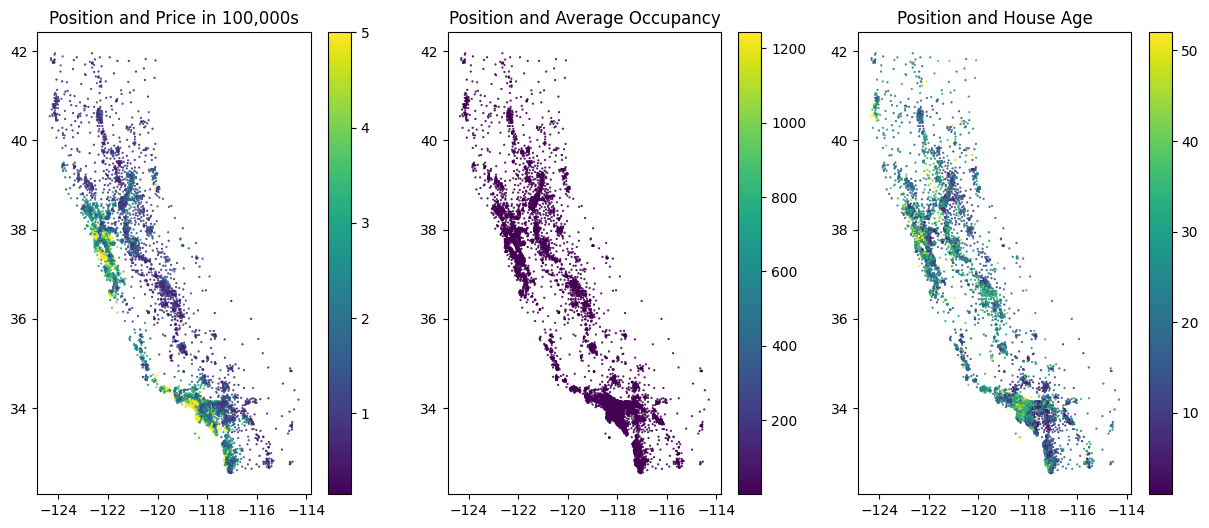

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

sc1 = axs[0].scatter(housing.data["Longitude"], housing.data["Latitude"], c=housing.target, s=0.3)
axs[0].set_title("Position and Price in 100,000s")
fig.colorbar(sc1)

sc2 = axs[1].scatter(housing.data["Longitude"], housing.data["Latitude"], c=housing.data["AveOccup"], s=0.3)
axs[1].set_title("Position and Average Occupancy")
fig.colorbar(sc2)

sc3 = axs[2].scatter(housing.data["Longitude"], housing.data["Latitude"], c=housing.data["HouseAge"], s=0.3)
axs[2].set_title("Position and House Age")
fig.colorbar(sc3)

Text(0.5, 1.0, 'HouseAge')

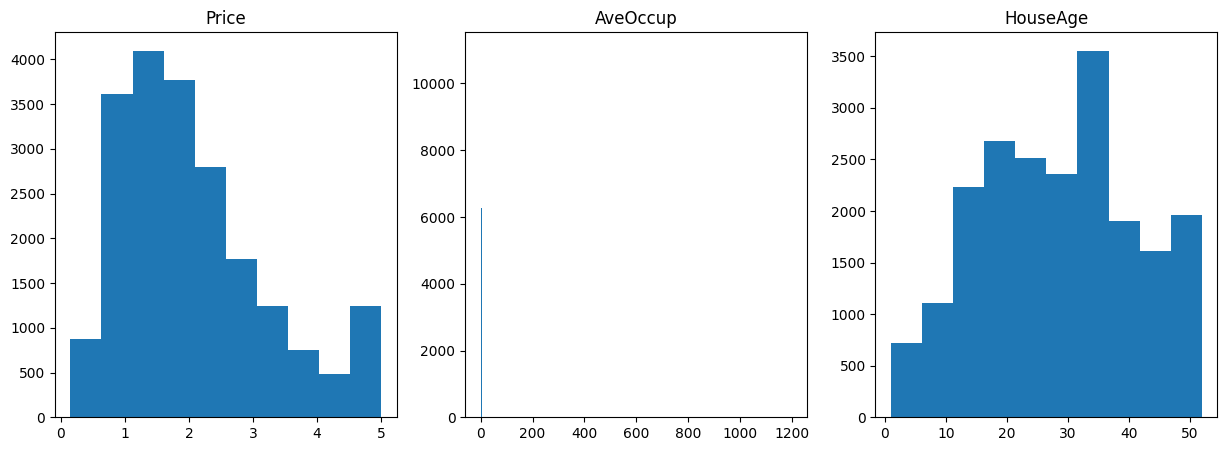

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(housing.target); # semi colon silences some unnecessary output
axs[0].set_title("Price")

axs[1].hist(housing.data["AveOccup"], bins=np.arange(1200));
axs[1].set_title("AveOccup")

axs[2].hist(housing.data["HouseAge"]);
axs[2].set_title("HouseAge")

37


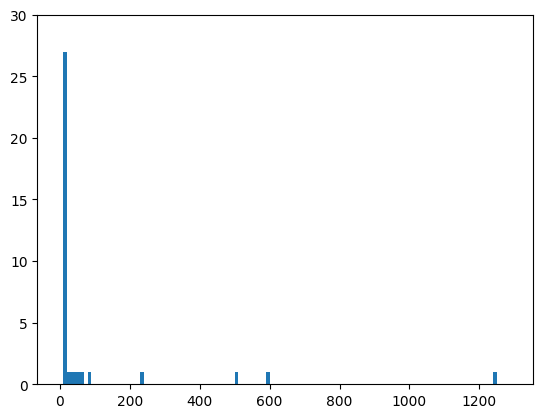

In [ ]:
# Vaguely interesting, there is a very dense neighbourhood, but large majority are small as would be expected
large_aveOccup_mask = housing.data["AveOccup"].to_numpy() > 10
print(np.count_nonzero(large_aveOccup_mask))
plt.hist(housing.data["AveOccup"][large_aveOccup_mask], bins=np.arange(1300, step=10))
plt.ylim(0, 30);

### Plain Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split

In [209]:
def get_train_test(frame):
    train_set, test_set = train_test_split(frame, test_size=0.2, random_state=42)

    train_X = train_set.drop(columns="MedHouseVal")
    train_y = train_set["MedHouseVal"]

    test_X = test_set.drop(columns="MedHouseVal")
    test_y = test_set["MedHouseVal"]

    return train_X, train_y, test_X, test_y

In [211]:
train_X, train_y, test_X, test_y = get_train_test(housing.frame)

In [ ]:
reg = LinearRegression().fit(train_X, train_y) # note that bias term is included by default

#### Performance Scores (candidates for fitness function)

In [221]:
r_squared = reg.score(train_X, train_y) # R^2 value says how much of the variance in the prices are explained by our model. 1.0 would be perfect
r_squared

0.6125511913966952

In [ ]:
r_squared = reg.score(test_X, test_y) # R^2 value says how much of the variance in the prices are explained by our model. 1.0 would be perfect
r_squared

# Increases with number of variables, so generally an adjusted version is used

0.5757877060324511

In [171]:
# n = number of samples
# p = number of variables/parameters/features/whatever you wanna call it
# the more variables, the lower R^2 adjusted is, so it penalizes adding more variables that don't improve the overall fit very much
def r_squared_adjusted(r_squared, n, p):
    return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

r_squared_adjusted(r_squared, len(train_X), len(train_X.columns))

0.5755820647337939

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error
from sklearn.metrics import mean_squared_error

predictions = reg.predict(test_X)
mse = mean_squared_error(test_y, predictions)
print(mse) # 0 is perfect (no errors) 

0.555891598695244


#### Example Predictions

In [ ]:
idx = 3
example = test_X.iloc[[idx]] # need extra pair of brackets cuz reg.predict wants 2 dimensions
print(f"Prediction: {reg.predict(example)[0]}")
print(f"True Value: {test_y.iloc[idx]}")

Prediction: 1.5658949182916828
True Value: 0.934


Text(0.5, 1.0, 'Errors')

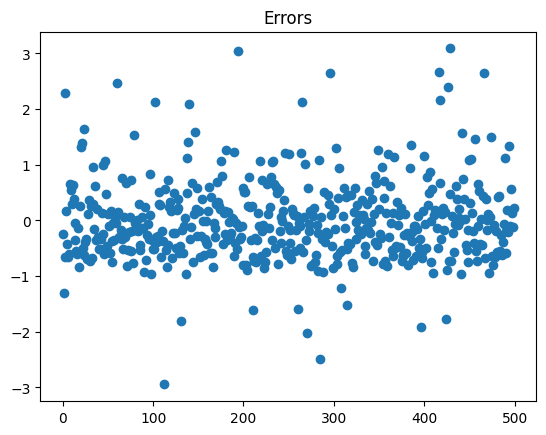

In [166]:
n = 500
plt.scatter(np.arange(n), test_y.iloc[:n] - predictions[:n])
plt.title("Errors")

### Feature Engineering

In [219]:
housing.frame.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')

In [200]:
eng_housing = housing.frame.copy()

eng_housing["bedrooms_per_room"] = housing.frame["AveBedrms"] / housing.frame["AveRooms"]
eng_housing["aveoccup_per_bedroom"] = housing.frame["AveOccup"] / housing.frame["AveBedrms"]
eng_housing["medinc_times_aveoccup"] = housing.frame["MedInc"] * housing.frame["AveOccup"]

eng_housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,bedrooms_per_room,aveoccup_per_bedroom,medinc_times_aveoccup
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,0.146591,2.496124,21.275511
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,0.155797,2.170886,17.514641
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,0.129516,2.610526,20.337121
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,0.184458,2.374468,14.378310
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,0.172096,2.017857,8.390359


In [215]:
eng_train_X, eng_train_y, eng_test_X, eng_test_y = get_train_test(eng_housing)

In [214]:
eng_reg = LinearRegression().fit(eng_train_X, eng_train_y)

In [ ]:
r_squared = eng_reg.score(eng_train_X, eng_train_y)
r_squared # Higher R^2 means better fit!

0.6255482534511689

In [ ]:
r_squared = eng_reg.score(eng_test_X, eng_test_y)
r_squared # Higher R^2 means better fit!

0.5997441359488783